<a href="https://colab.research.google.com/github/DavideBruni/CIDL_lab/blob/main/AutoEncoder_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

In [ ]:
class Autoencoder(torch.nn.Module):
  def __init__(self, input_dim, bottleneck_dim):
    super(Autoencoder, self).__init__()
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,bottleneck_dim)
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(bottleneck_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,input_dim)
    )

  def encode(self,x):
    return self.encoder(x)

  def decode(self,x):
    return self.decoder(x)

  def forward(self,x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return latent, reconstructed

In [ ]:
import torchvision
train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

In [ ]:
from tqdm import tqdm
ae = Autoencoder(784,2)
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
dl = torch.utils.data.DataLoader(train_mnist, batch_size=32,shuffle=True)
ae.to('cuda')

for epoch in range(10):
  bar = tqdm(dl)
  latents = []
  for batch, _ in bar:
    batch = batch.to('cuda')
    batch = batch.reshape(batch.size(0), -1)
    latent, reconstruct = ae(batch)
    latents.append(latent)
    error = loss_fn(reconstruct,batch)
    optimizer.zero_grad()
    error.backward()
    optimizer.step()


100%|██████████| 1875/1875 [00:18<00:00, 102.41it/s]


In [ ]:
print(len(latents))

1875


In [ ]:
test_ds = test_mnist
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
latent_points_test = []
labels_test = []

with torch.no_grad():
    for batch, label in test_dl:
        batch = batch.to('cuda')
        batch = batch.view(batch.size(0), -1)
        latent, _   = ae(batch)
        latent_points_test.append(latent.cpu().numpy())
        labels_test.append(label.numpy())

latent_points_test = np.vstack(latent_points_test)
labels_test = np.concatenate(labels_test)

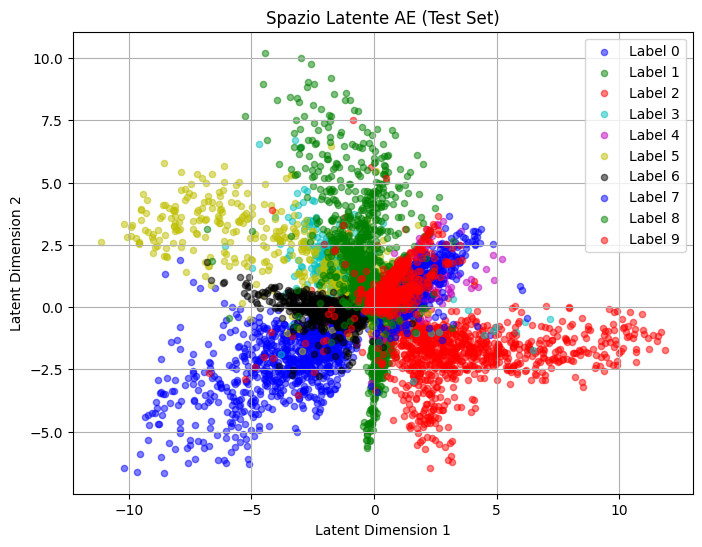

In [ ]:
# Definisci un set di colori per le diverse etichette
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Crea un grafico a dispersione
plt.figure(figsize=(8, 6))
for label in np.unique(labels_test):
    indices = labels_test == label
    color_idx = label % len(colors)  # Utilizza l'indice del colore ciclicamente
    plt.scatter(latent_points_test[indices, 0], latent_points_test[indices, 1], c=colors[color_idx],
                label=f'Label {label}', s=20, alpha=0.5)

plt.title('Spazio Latente AE (Test Set)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

# MLP Classifier

In [ ]:
min_x = -10
max_x = 10
min_y = -10
max_y = 10

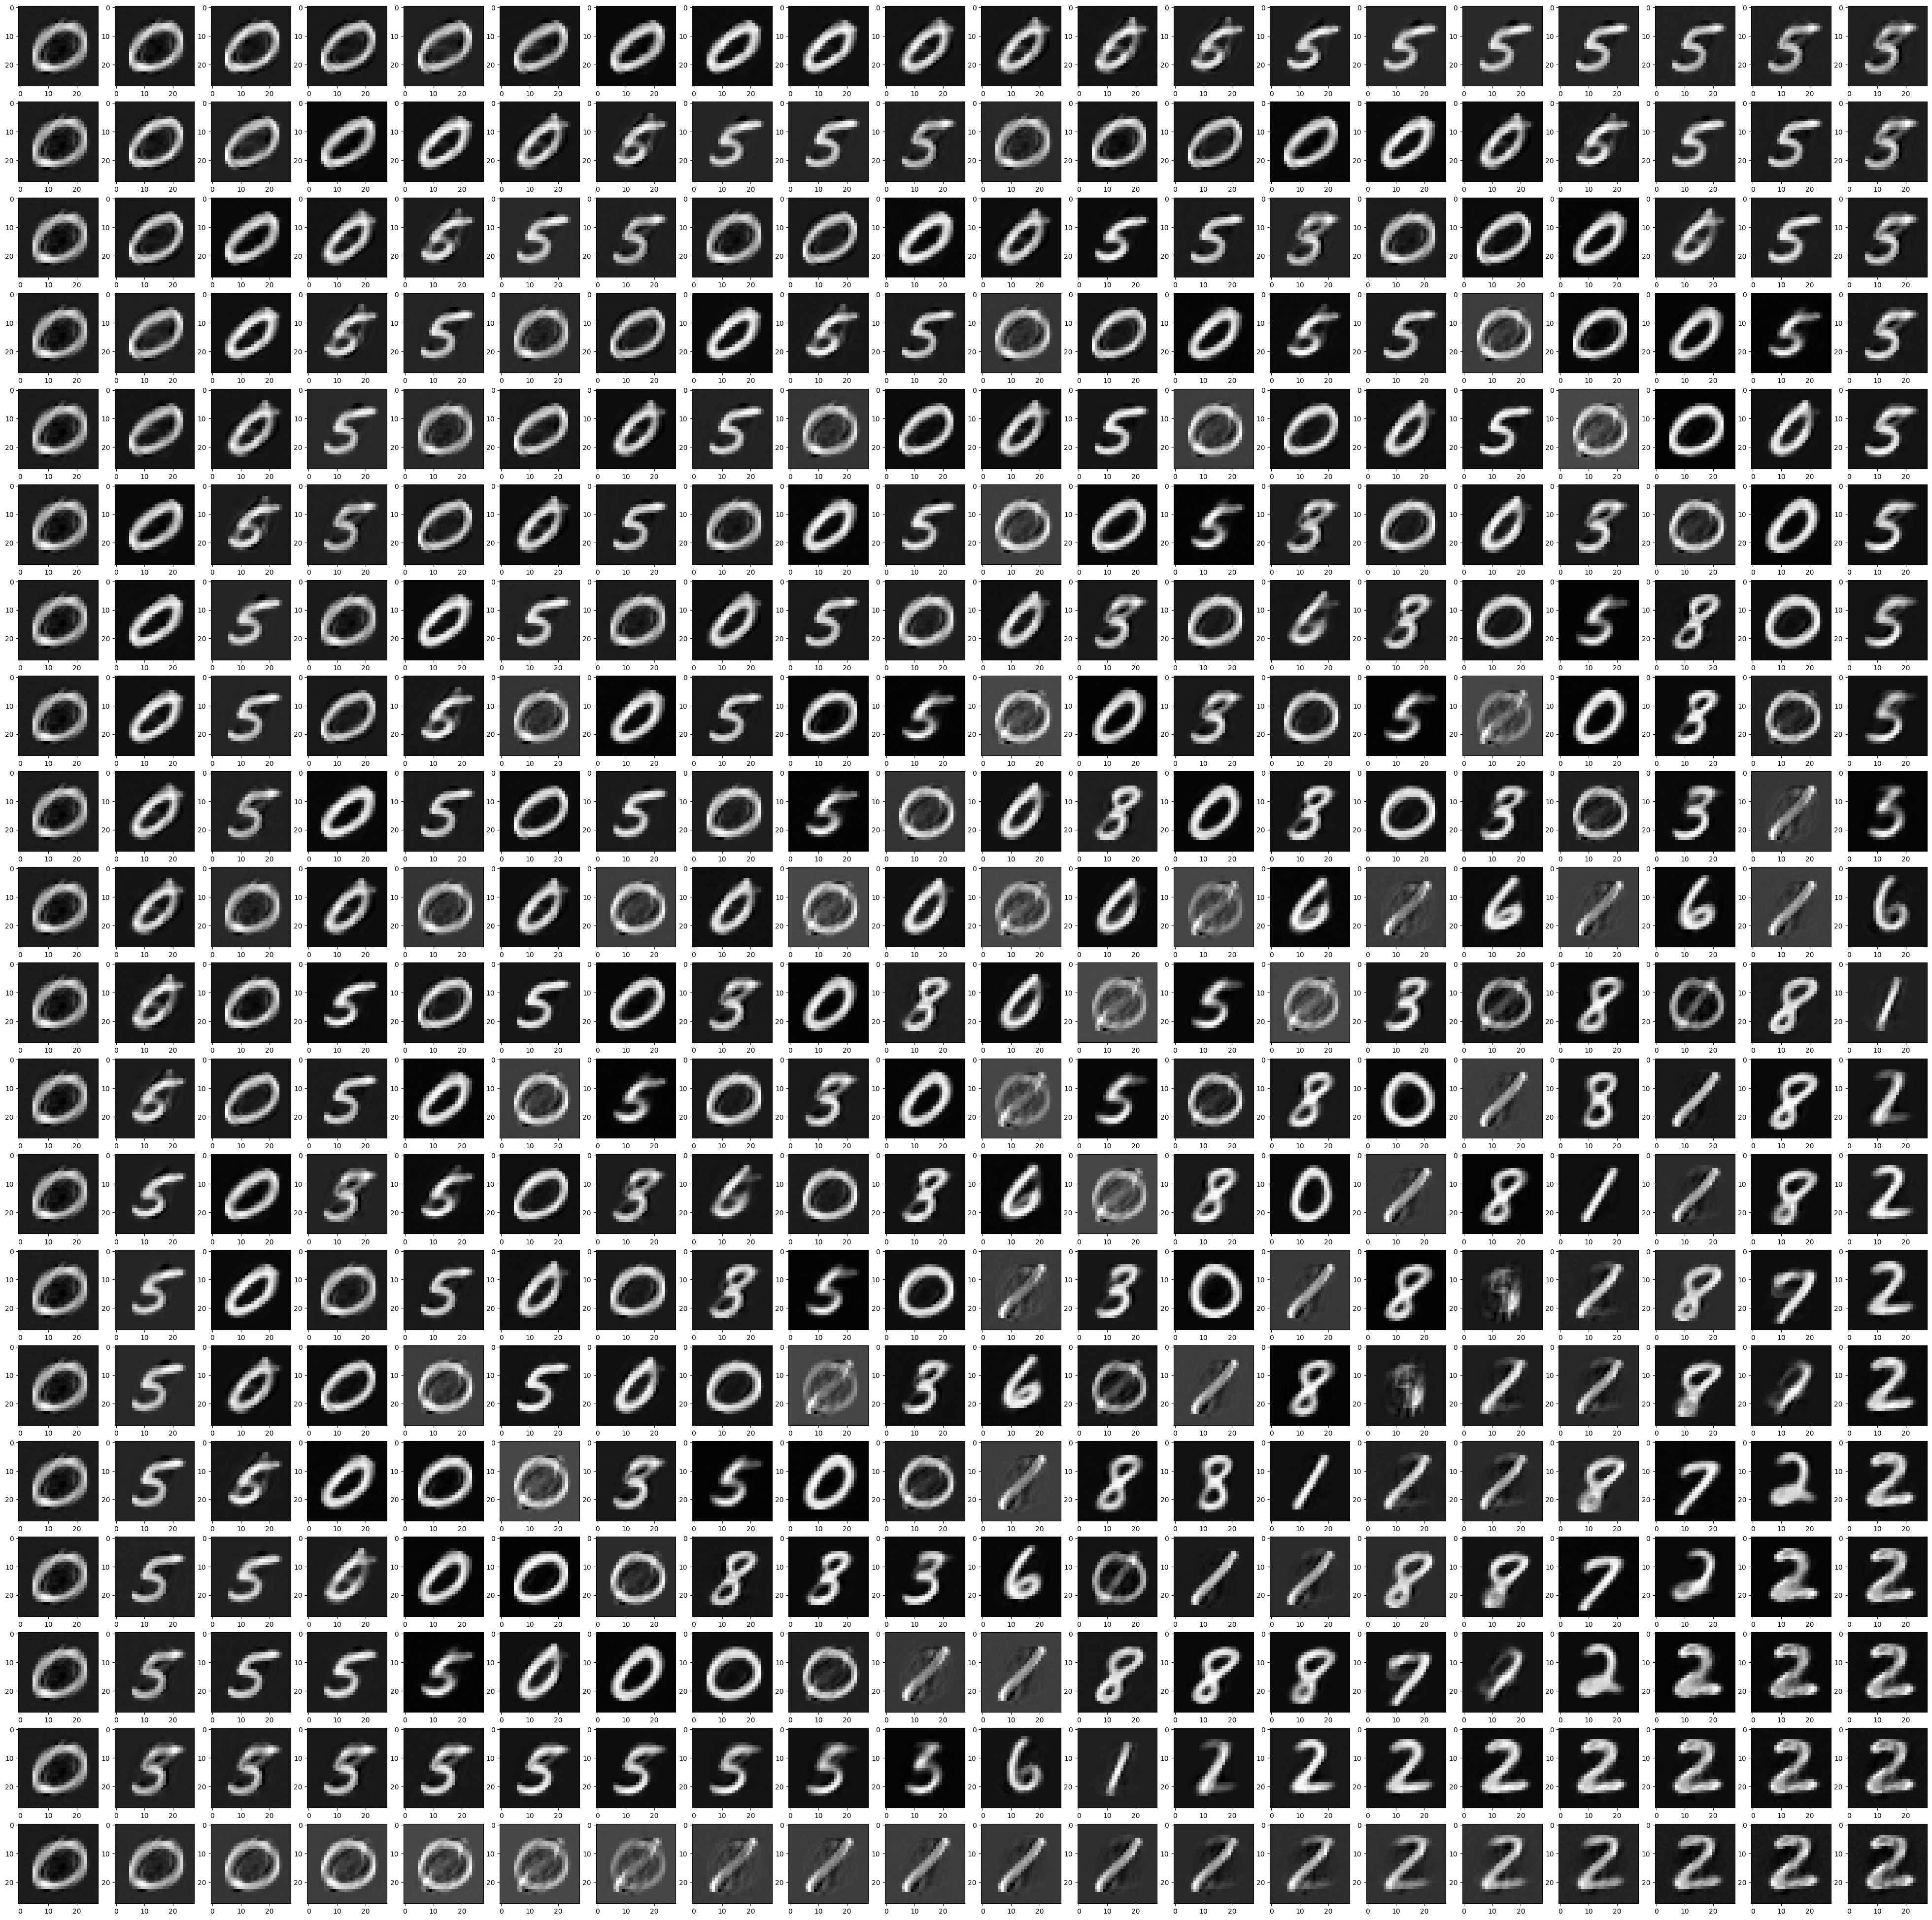

In [ ]:
images = []
for x in range(min_x, max_x):
  for y in range(min_y,max_y):
    tensor = torch.tensor([x,y], dtype=torch.float)
    tensor = tensor.to('cuda')
    image = ae.decode(tensor)
    image = image.to('cuda')
    image = image.reshape(28, 28)
    images.append(image)


fig, axes = plt.subplots(20, 20, figsize=(50, 50))
for i in range(0, 20):
    for j in range(0,20):
      axes[i, j].imshow(images[j + i*j].detach().cpu().numpy().squeeze(), cmap="gray")
plt.show()
